## Matrix factorization script

In [ ]:
from numpy import random as rd
from random import sample
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import time
import matplotlib.pyplot as plt
from math import floor, log2
from copy import deepcopy as dc
import random
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

### 1.1 Matrix help functions

In [ ]:
def open_df(name):
  df = pd.read_csv(name)
  df = df.drop(columns = 'Unnamed: 0')
  return df

In [ ]:
def df_to_matrix(df, m, n):
  R = csr_matrix((df.rating, (df.user, df.item)), shape=(m, n)).toarray()
  shuffle_matrix(R)
  R = R.astype(np.float64)
  return(R)

In [ ]:
def shuffle_matrix(R):
  rd.shuffle(R)
  rd.shuffle(np.transpose(R))

In [ ]:
def get_nonzero_count(R):
  return np.count_nonzero(R)

In [ ]:
def get_total_count(R):
  return R.shape[0]*R.shape[1]

In [ ]:
def get_sparsity(R):
  return get_nonzero_count(R)/get_total_count(R)

In [ ]:
def get_number_to_delete(R, sparsity):
  # For a matrix R, calculate how many items to delete to get new sparsity
  total_elements = get_total_count(R)
  current_nonzero_elements = get_nonzero_count(R)
  new_nonzero_elements = round(total_elements * sparsity)
  return current_nonzero_elements - new_nonzero_elements

In [ ]:
def get_index_list(R):
  [u_ind, m_ind] = np.nonzero(R)
  return list(zip(u_ind, m_ind))

In [ ]:
def make_sparser(R, sparsity):
  assert sparsity <= get_sparsity(R), "Sparsity is higher than the current matrix sparsity"
  delete_number = get_number_to_delete(R, sparsity)
  index_list = get_index_list(R)
  indices = sample(index_list, delete_number)
  for (u,m) in indices:
    R[u,m] = 0

In [ ]:
def split_in_two(R, p):
  # p = proportion of input matrix that goes into second output matrix

  r1 = dc(R)
  r2 = np.zeros(R.shape)

  for user in range(R.shape[0]):
    ulist = R[user, :].nonzero()[0]
    l = len(ulist)
    if l >= 10:
      random.shuffle(ulist)
      r2_ratings = ulist[:round(p*l)]
    else:
      r2_ratings = []
      for u in ulist:
        num = random.uniform(0,1)
        if num < p:
          r2_ratings.append(u)

    r1[user, r2_ratings] = 0
    r2[user, r2_ratings] = R[user, r2_ratings]

  # Assert that matrices are disjoint
  assert(np.all((r1 * r2) == 0))
  return r1, r2

In [ ]:
def calc_mean(R):
  mask = np.nonzero(R)
  return np.mean(R[mask])

In [ ]:
def add_const(R, mu):
  mask = np.nonzero(R)
  R[mask] = R[mask] + mu

In [ ]:
def split_into_train_test(R, spars_train):
  ratings_train = get_total_count(R)*spars_train
  ratings_test = get_nonzero_count(R) - ratings_train
  prop_to_test = ratings_test/get_nonzero_count(R)

  train, test = split_in_two(R, prop_to_test)
  return train, test

In [ ]:
def filter_out_test_ratings(Rhat, Test):
  Res = np.zeros(Rhat.shape)
  mask = np.nonzero(Test)
  Res[mask] = Rhat[mask]
  return Res

### 1.2 Optimization help functions

In [ ]:
def initialize_latent_factors(m,n,l):
  U = rd.uniform(-1, 1, [m, l])
  V = rd.uniform(-1, 1, [n, l])
  #U = rd.rand(m,l)-0.5; V = rd.rand(n,l)-0.5
  return U, V

In [ ]:
def initialize_biases(m,n):
  c = rd.uniform(-1, 1, m)
  d = rd.uniform(-1, 1, n)
  #c = [0]*m; d = [0]*n
  return c, d

In [ ]:
def als_step(R, solve_mat, fixed_mat, l, lam):
  A = fixed_mat.T.dot(fixed_mat) + np.eye(l) * lam
  b = R.dot(fixed_mat)
  A_inv = np.linalg.inv(A)
  solve_mat = b.dot(A_inv)
  return solve_mat

In [ ]:
def als_step_biased(R, solve_mat, fixed_mat, solve_bias, fixed_bias, l, lam):
  Rbias = subtract_bias(R,fixed_bias)
  solve_mat_biased = biased_mat(solve_mat, solve_bias)
  fixed_mat_biased = biased_mat(fixed_mat, fixed_bias)
  solve_mat_biased = als_step(Rbias, solve_mat_biased, fixed_mat_biased, l+1, lam)
  solve_mat = solve_mat_biased[:,1:]
  solve_bias = solve_mat_biased[:,0]
  return solve_mat, solve_bias

In [ ]:
def subtract_bias(R,bias):
  Rbias = dc(R)
  for col in range(R.shape[1]):
    Rbias[:,col] -= bias[col]
  return Rbias

In [ ]:
def biased_mat(M,bias):
  (k,l) = np.shape(M)
  Mbias = np.zeros((k,l+1))
  Mbias[:,0] = bias
  Mbias[:,1:] = M
  return Mbias

In [ ]:
def compute_rmse(y_true, y_pred):
  mask = np.nonzero(y_true)
  rmse = np.sqrt(np.square(y_true[mask] - y_pred[mask]).mean())
  return rmse

In [ ]:
def compute_mae(y_true, y_pred):
  mask = np.nonzero(y_true)
  mae = np.absolute(y_true[mask] - y_pred[mask]).mean()
  return mae

In [ ]:
def compute_diff(y_true, y_pred):
  mask = np.nonzero(y_true)
  diff = np.zeros(y_true.shape)
  diff[mask] = y_true[mask] - y_pred[mask]
  return diff

In [ ]:
def tune_hyperparams(Tr, Val, tol, latent_factors, lambdas, bias, once):
  ### Find best hyperparameters lambda and l
  best_params = {}
  best_params['n_factors'] = latent_factors[0]
  best_params['reg'] = lambdas[0]
  best_params['train_rmse'] = np.inf
  best_params['val_rmse'] = np.inf

  for lam in lambdas:
    for l in latent_factors:
        res = optimize(Tr, Val, tol, l, lam, bias, once)
        if res[1] < best_params['val_rmse']:
            best_params['n_factors'] = l
            best_params['reg'] = lam
            best_params['train_rmse'] = res[0]
            best_params['val_rmse'] = res[1]
  #print('Optimal hyperparameters:')
  #print(pd.Series(best_params))
  return(best_params['n_factors'], best_params['reg'])

In [ ]:
def optimize(train, test, tol, l, lam, bias = False, once = False):
  ### Optimization algorithm

  # Preprocessing: subtract the mean of train, from train, test and val
  mu = calc_mean(train)
  add_const(train, -mu); add_const(test, -mu);

  # Initialize U, V, and bias vectors
  (m,n) = np.shape(train)
  U,V = initialize_latent_factors(m,n,l)
  if bias:
    c, d = initialize_biases(m,n)

  # Results
  RMSE_tr = [1000]  # first element is only for comparison with next RMSE, is deleted after optimization run
  RMSE_te = []
  MAE_tr = []
  MAE_te = []
  Rhat = U.dot(V.T)
  Rhat_list = [Rhat]
  Ulist = []
  Vlist = []
  improvement = 0

  # ALS optimization
  while improvement < tol:

    RMSE_tr.append(compute_rmse(train, Rhat))
    RMSE_te.append(compute_rmse(test, Rhat))
    MAE_tr.append(compute_mae(train,Rhat))
    MAE_te.append(compute_mae(test,Rhat))

    if bias:
      U, c = als_step_biased(train, U, V, c, d, l, lam)
      V, d = als_step_biased(train.T, V, U, d, c, l, lam)
    else:
      U = als_step(train, U, V, l, lam)
      V = als_step(train.T, V, U, l, lam)
    Ulist.append(U); Vlist.append(V)
    Rhat = U.dot(V.T)
    Rhat_list.append(Rhat)
    improvement = RMSE_tr[-1]/RMSE_tr[-2]

  del RMSE_tr[0]

  # Postprocessing: add the global mean back to train, val and test
  add_const(train, mu); add_const(test, mu)

  if once:
    return RMSE_tr, RMSE_te
  else:
    return (RMSE_tr[-1], RMSE_te[-1], MAE_tr[-1], MAE_te[-1], Rhat)

### 1.3 Post-optimization functions

In [ ]:
def compute_ground_truth_ranking(Test, topk):
  ground_truth = np.zeros((Test.shape[0], len(topk)), dtype=object)
  for user in range(Test.shape[0]):
    for i_k, k in enumerate(topk):
      ground_truth[user, i_k] = np.argsort(-Test[user,:]).tolist()[:k]
      ground_truth[user, i_k] = np.argsort(-Test[user,:]).tolist()[:k]
  return ground_truth

In [ ]:
def compute_full_ranking_for_user(M, user): # returns a set of top-k recommended items for one user
  return np.argsort(-M[user,:]).tolist()

In [ ]:
def compute_ground_truth_set_diffs(ground_truth_rankings, topk_rankings):
  dim = topk_rankings.shape
  diff_first, diff_prev, diff_ground_truth = np.zeros(dim), np.zeros(dim), np.zeros(dim)
  for it in range(dim[0]):
    for s in range(dim[1]):
      for u in range(dim[2]):
        for k in range(dim[3]):
          diff_ground_truth[it, s, u, k] = compute_set_diff_for_user(topk_rankings[it, s, u, k], ground_truth_rankings[it, u, k])
          diff_first[it, s, u, k] = compute_set_diff_for_user(topk_rankings[it, s, u, k], topk_rankings[it, 0, u, k])
          if s-1 >= 0:
            diff_prev[it, s, u, k] = compute_set_diff_for_user(topk_rankings[it, s, u, k], topk_rankings[it, s-1, u, k])
  diff_ground_truth = average_over_axis(diff_ground_truth, 2)
  #diff_first = average_over_axis(diff_first, (0,2))
  #diff_prev = average_over_axis(diff_prev, (0,2))
  return diff_ground_truth#, diff_first, diff_prev

In [ ]:
def compute_relative_set_diffs(rankings, sparsity_levels, iterations, m, topk):
  # topk_rankings = np.zeros((iterations, len(sparsity_levels), m, len(topk)), dtype=object)
  combinations = sum(range(iterations))
  diffs = np.zeros((combinations, len(sparsity_levels), m, len(topk)), dtype=object)
  for i_s, s in enumerate(sparsity_levels):
    for i_k, k in enumerate(topk):
      for i_m in range(m):
        rankings_list = list(rankings[:, i_s, i_m, i_k])
        pairwise_list = list(itertools.combinations(rankings_list,2))
        for i_r, (r1,r2) in enumerate(pairwise_list):
          diffs[i_r, i_s, i_m, i_k] = compute_set_diff_for_user(r1, r2)
  diffs = average_over_axis(diffs, 2)
  return diffs

In [ ]:
def compute_set_diff_for_user(r1, r2):
  k = len(r1)
  set1, set2 = set(r1), set(r2)
  return len(set1.difference(set2))/k

In [ ]:
def average_over_axis(array, axes):
  return np.average(array, axis=axes)

In [ ]:
def compute_R_score_for_user(Test, ranking, alpha, user, k):
  R_score = 0
  for item in ranking:
    R_score += compute_R_score_for_item(Test, ranking, alpha, user, item, k)
  return R_score

In [ ]:
def compute_R_score_for_item(Test, ranking, alpha, user, item, k):
  C = np.mean(Test[user, :])
  r = Test[user, item]
  v = ranking.index(item) + 1    # +1 since ranking starts at 1 while indexing starts at 0
  if r - C > 0:
    return (r - C)/(2**((v-1)/alpha))
  else:
    return 0

In [ ]:
def compute_NDCG_for_user(Test, ranking, user, k):
  DCG = compute_DCG_for_user(Test, ranking, user, k)
  gnd_truth_ranking = compute_full_ranking_for_user(Test, user)[:k]
  IDCG = compute_DCG_for_user(Test, gnd_truth_ranking, user, k)
  return DCG/IDCG

In [ ]:
def compute_DCG_for_user(Test, ranking, user, k):
  DCG = []
  for item in ranking:
    DCG.append(compute_DCG_for_item(Test, ranking, user, item, k))
  return np.mean(DCG)

In [ ]:
def compute_DCG_for_item(Test, ranking, user, item, k):
  r = Test[user, item]
  g = 2**(r-1)
  v = ranking.index(item) + 1
  return g/log2(v+1)

### 2.1 Main scripts

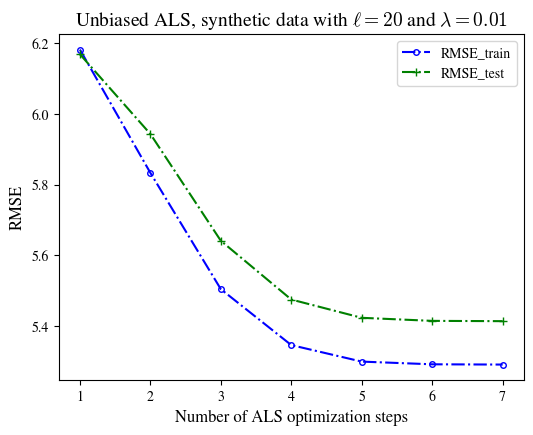

In [ ]:
def main_one_als_optimization():
  ### Produces a plot of RMSE for train and test set during one optimization run
  df_dense = open_df('df_size_2000_2000_l_20.csv')
  m = df_dense.user.nunique()
  n = df_dense.item.nunique()
  R = df_to_matrix(df_dense, m, n)

  ########    Set all parameters needed    ######################################

  bias = False      # biased or unbiased ALS method
  once = True       # run the optimization only once, in order to plot the decrease in RMSE during one training
  initialisation_test = False
  method = 'Biased ALS' if bias else 'Unbiased ALS'
  tol = 0.999;      # tolerance: run optimization until train RMSE doesn't improve more than 1 - tol.
  save_figs = True
  np.random.seed(0)

  ########    End of parameters    ##############################################

  Train, Test = split_into_train_test(R, 0.1)
  l, lam = 20, 0.01
  rmse_tr, rmse_te = optimize(Train, Test, tol, l, lam, bias, once)

  # Plot:
  plt.plot(np.arange(1,len(rmse_tr)+1), rmse_tr, 'bo-.', label='RMSE_train', markerfacecolor='none', markersize=4)
  plt.plot(np.arange(1,len(rmse_tr)+1), rmse_te, 'g+-.', label='RMSE_test')
  plt.title(method + ', synthetic data with $\ell=20$ and $\lambda = 0.01$', fontsize=14)
  plt.xlabel('Number of ALS optimization steps', fontsize=12)
  plt.xticks(np.arange(1,len(rmse_tr)+1))
  plt.ylabel('RMSE', fontsize=12)
  fig = plt.gcf()
  fig.set_size_inches(6, 4.5)
  plt.legend(loc='upper right')
  name = 'ALS_one_optimization_synthetic.eps'
  plt.savefig(name, format='eps', dpi=300, bbox_inches='tight')
  plt.show()

main_one_als_optimization()

In [ ]:
def main_tune_hyperparameters():
  ### Tunes regularization parameter for different sparsity levels

  df_dense = open_df('df_size_2000_2000.csv')
  m = df_dense.user.nunique()
  n = df_dense.item.nunique()
  R = df_to_matrix(df_dense, m, n)

  ########    Set all parameters needed    ######################################

  tune_lambda = True
  tune_ell = False

  bias = True      # biased or unbiased ALS method
  tol = 0.99;      # tolerance: run optimization until train RMSE doesn't improve more than 1 - tol.
  save_figs = False

  #For the synthetic data set:
  #latent_factors = [20]
  #lambdas = [0, 1e-06, 2e-06, 3e-06, 5e-06, 7.5e-06]
  #sparsity_levels = [0.9, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01]

  #For the Netflix data:
  sparsity_levels = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
  latent_factors = [35, 40, 45, 50]
  lambdas = [0.005, 0.0075, 0.01, 0.015]
  n_tunings = 10

  ########    End of parameters    ##############################################

  if tune_lambda:
    latent_factors = [40]
    lambda_results = np.zeros((len(sparsity_levels), n_tunings), dtype=object)
    for i_n in range(n_tunings):
      Train, Val = split_into_train_test(R, sparsity_levels[0])
      for i_s, sparsity in enumerate(sparsity_levels):
        make_sparser(Train, sparsity)
        l, lam = tune_hyperparams(Train, Val, tol, latent_factors, lambdas, bias, once=False)
        lambda_results[i_s, i_n] = lam
    for el in lambda_results:
      print(el)
    return lambda_results

  if tune_ell:
    lambdas = [0]
    latent_factors_results = []
    for _ in range(n_tunings):
      Train, Val = Train, Test = split_into_train_test(R, sparsity_levels[0])
      l, lam = tune_hyperparams(Train, Val, tol, latent_factors, lambdas, bias, once=False)
      latent_factors_results.append(l)
      print(l, lam)
      return latent_factors

res = main_tune_hyperparameters()

[0.0075 0.01 0.0075 0.015 0.0075 0.01 0.015 0.015 0.01 0.005]
[0.015 0.005 0.005 0.015 0.0075 0.01 0.01 0.005 0.005 0.015]
[0.01 0.005 0.015 0.0075 0.005 0.005 0.015 0.01 0.01 0.005]
[0.01 0.01 0.005 0.0075 0.01 0.005 0.01 0.01 0.01 0.005]
[0.0075 0.0075 0.005 0.015 0.005 0.015 0.015 0.005 0.015 0.005]
[0.01 0.015 0.015 0.015 0.015 0.0075 0.01 0.015 0.01 0.005]
[0.005 0.005 0.005 0.01 0.01 0.0075 0.005 0.005 0.01 0.005]


In [ ]:
### Main numerical tests:

start_time = time.time()
df_dense = open_df('df_size_2000_2000.csv')
m = df_dense.user.nunique()
n = df_dense.item.nunique()
R = df_to_matrix(df_dense, m, n)

########    Set all parameters needed    ######################################

np.random.seed(0)

iterations = 10
bias = True                  # biased or unbiased ALS method
tol = 0.999;                   # tolerance: run optimization until train RMSE doesn't improve more than 1 - tol.
topk = [5, 10, 20]               # top-k recommended items
alpha = 4

# For the synthetic data set:
sparsity_levels = [0.9, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01]
l, lam = 20, 0

# For the Netflix data set:
sparsity_levels = [0.55, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
l, lam = 45, 0.01

########    End of parameters    ##############################################

full_rankings = np.zeros((iterations, len(sparsity_levels), m), dtype=object)
topk_rankings = np.zeros((iterations, len(sparsity_levels), m, len(topk)), dtype=object)
ground_truth_rankings = np.zeros((iterations, m, len(topk)), dtype=object)
R_score = np.zeros((iterations, len(sparsity_levels), m, len(topk)), dtype=object)
NDCG = np.zeros((iterations, len(sparsity_levels), m, len(topk)), dtype=object)
diff_ground_truth = np.zeros((iterations, len(sparsity_levels), m, len(topk)), dtype=object)
rmse_tr_te = np.zeros((iterations, len(sparsity_levels), 2), dtype=object)
mae_tr_te = np.zeros((iterations, len(sparsity_levels), 2), dtype=object)

###  Start iterations  #######

for it in range(iterations):

  Train, Test = split_into_train_test(R, sparsity_levels[0])
  ground_truth_rankings[it, :, :] = compute_ground_truth_ranking(Test, topk)

  for i_s, sparsity in enumerate(sparsity_levels):
    make_sparser(Train, sparsity)
    result = optimize(Train, Test, tol, l, lam, bias, once=False)
    rmse_tr_te[it, i_s, :] = result[0:2]
    mae_tr_te[it, i_s, :] = result[2:4]
    Rhat = result[4]
    Rhat_test = filter_out_test_ratings(Rhat, Test)
    for user in range(m):
      full_rankings[it, i_s, user] = compute_full_ranking_for_user(Rhat_test, user)
      for i_k, k in enumerate(topk):
        estimated_ranking = full_rankings[it, i_s, user][:k]
        topk_rankings[it, i_s, user, i_k] = estimated_ranking
        R_score[it, i_s, user, i_k] = compute_R_score_for_user(Test, estimated_ranking, alpha, user, k)
        NDCG[it, i_s, user, i_k] = compute_NDCG_for_user(Test, estimated_ranking, user, k)

rmse_train = rmse_tr_te[:, :, 0]
rmse_test = rmse_tr_te[:, :, 1]
mae_train = mae_tr_te[:, :, 0]
mae_test = mae_tr_te[:, :, 1]

R_score = average_over_axis(R_score, (0,2))
NDCG = average_over_axis(NDCG, (0,2))

rmse_tr_te = average_over_axis(rmse_tr_te, 0)
rmse_train_avg = rmse_tr_te[:, 0]
rmse_test_avg = rmse_tr_te[:, 1]

mae_tr_te_avg = average_over_axis(mae_tr_te, 0)
mae_train_avg = mae_tr_te_avg[:, 0]; mae_test_avg = mae_tr_te_avg[:, 1]

diff_ground_truth = compute_ground_truth_set_diffs(ground_truth_rankings, topk_rankings)
diff_ground_truth_averaged = average_over_axis(diff_ground_truth, 0)

t = (time.time() - start_time)/60
print("Execution time for this run: %.2f minutes \n" % t)

Execution time for this run: 8.33 minutes 



In [ ]:
def print_statistics(rmse_train, rmse_test, mae_train, mae_test, diff_ground_truth, sparsity_levels):

  rmse_statistics_tr = [[],[]]
  mae_statistics_tr = [[],[]]
  rmse_statistics_te = [[], []]
  mae_statistics_te = [[],[]]
  diff_statistics_k_5 = [[], []]
  diff_statistics_k_10 = [[], []]
  diff_statistics_k_20 = [[], []]

  spars = sparsity_levels[::-1]
  dec = 4

  for i_s, s in enumerate(sparsity_levels):
    rmse_statistics_tr[0][:0] = [round(np.mean(rmse_train[:,i_s]), dec)]
    rmse_statistics_tr[1][:0] = [round(np.std(rmse_train[:,i_s]), dec)]
    mae_statistics_tr[0][:0] = [round(np.mean(mae_train[:,i_s]), dec)]
    mae_statistics_tr[1][:0] = [round(np.std(mae_train[:,i_s]), dec)]
    rmse_statistics_te[0][:0] = [round(np.mean(rmse_test[:,i_s]), dec)]
    rmse_statistics_te[1][:0] = [round(np.std(rmse_test[:,i_s]), dec)]
    mae_statistics_te[0][:0] = [round(np.mean(mae_test[:,i_s]), dec)]
    mae_statistics_te[1][:0] = [round(np.std(mae_test[:,i_s]), dec)]
    diff_statistics_k_5[0][:0] = [round(np.mean(diff_ground_truth[:, i_s, 0]), dec)]
    diff_statistics_k_5[1][:0] = [round(np.std(diff_ground_truth[:, i_s, 0]), dec)]
    diff_statistics_k_10[0][:0] = [round(np.mean(diff_ground_truth[:, i_s, 1]), dec)]
    diff_statistics_k_10[1][:0] = [round(np.std(diff_ground_truth[:, i_s, 1]), dec)]
    diff_statistics_k_20[0][:0] = [round(np.mean(diff_ground_truth[:, i_s, 2]), dec)]
    diff_statistics_k_20[1][:0]= [round(np.std(diff_ground_truth[:, i_s, 2]), dec)]

  print('Sparsity levels: ', ' & '.join(str(x) for x in sparsity_levels[::-1]))
  print('RMSE_tr mean: ', ' & '.join(str(x) for x in rmse_statistics_tr[0]))
  print('RMSE_tr std: ', ' & '.join(str(x) for x in rmse_statistics_tr[1]))
  print('MAE_tr mean: ', ' & '.join(str(x) for x in mae_statistics_tr[0]))
  print('MAE_tr std: ', ' & '.join(str(x) for x in mae_statistics_tr[1]))

  print('RMSE_te mean: ', ' & '.join(str(x) for x in rmse_statistics_te[0]))
  print('RMSE_te std: ', ' & '.join(str(x) for x in rmse_statistics_te[1]))
  print('MAE_te mean: ', ' & '.join(str(x) for x in mae_statistics_te[0]))
  print('MAE_te std: ', ' & '.join(str(x) for x in mae_statistics_te[1]))

  print('k=5 mean: ', ' & '.join(str(x) for x in diff_statistics_k_5[0]))
  print('k=5 std: ', ' & '.join(str(x) for x in diff_statistics_k_5[1]))
  print('k=10 mean: ', ' & '.join(str(x) for x in diff_statistics_k_10[0]))
  print('k=10 std: ', ' & '.join(str(x) for x in diff_statistics_k_10[1]))
  print('k=20 mean: ', ' & '.join(str(x) for x in diff_statistics_k_20[0]))
  print('k=20 std: ', ' & '.join(str(x) for x in diff_statistics_k_20[1]))

print_statistics(rmse_train, rmse_test, mae_train, mae_test, diff_ground_truth, sparsity_levels)

Sparsity levels:  0.01 & 0.05 & 0.1 & 0.2 & 0.3 & 0.4 & 0.55
RMSE_tr mean:  0.9942 & 0.9882 & 0.9724 & 0.936 & 0.8996 & 0.8687 & 0.8408
RMSE_tr std:  0.004 & 0.0018 & 0.0012 & 0.0008 & 0.0009 & 0.0007 & 0.0012
MAE_tr mean:  0.8395 & 0.8327 & 0.816 & 0.777 & 0.7371 & 0.7034 & 0.673
MAE_tr std:  0.0031 & 0.0015 & 0.0011 & 0.0007 & 0.0007 & 0.0007 & 0.0011
RMSE_te mean:  1.0989 & 1.0901 & 1.0712 & 1.0292 & 0.9857 & 0.9463 & 0.9052
RMSE_te std:  0.0013 & 0.0014 & 0.0014 & 0.0019 & 0.0015 & 0.0015 & 0.0014
MAE_te mean:  0.9218 & 0.9124 & 0.8931 & 0.8493 & 0.8036 & 0.7632 & 0.7232
MAE_te std:  0.0011 & 0.0012 & 0.0013 & 0.0017 & 0.0013 & 0.0013 & 0.0012
k=5 mean:  0.9336 & 0.9042 & 0.8716 & 0.8374 & 0.8096 & 0.7915 & 0.7773
k=5 std:  0.0021 & 0.0022 & 0.0021 & 0.0017 & 0.0019 & 0.0028 & 0.0044
k=10 mean:  0.8765 & 0.8361 & 0.7921 & 0.7404 & 0.7075 & 0.6873 & 0.6712
k=10 std:  0.0018 & 0.0025 & 0.0027 & 0.0023 & 0.0028 & 0.0026 & 0.0026
k=20 mean:  0.7687 & 0.7182 & 0.6687 & 0.6151 & 0.5866 &

### 2.2 Plots

In [ ]:
def titles_and_file_names(synthetic, bias):
  if synthetic:
    title1 = 'Synthetic data: Error on the training and test set'
    title2 = 'Synthetic data: Set difference'
    title3 = 'Synthetic data: NDCG'
    title4 = 'Synthetic data: R-score'
    file1 = 'synthetic_error.eps'
    file2 = 'synthetic_set_diff.eps'
    file3 = 'synthetic_NDCG.eps'
    file4 = 'synthetic_R_score.eps'
  else:
    if bias:
      title1 = 'Netflix data, biased ALS: Error on the training and test set'
      title2 = 'Netflix data, biased ALS: Set difference'
      title3 = 'Netflix data, biased ALS: NDCG'
      title4 = 'Netflix data, biased ALS: R-score'
      file1 = 'netflix_bias_error.eps'
      file2 = 'netflix_bias_set_diff.eps'
      file3 = 'netflix_bias_NDCG.eps'
      file4 = 'netflix_bias_R_score.eps'
    else:
      title1 = 'Netflix data, ALS: RMSE on the training and test set'
      title2 = 'Netflix data, ALS: Set difference'
      title3 = 'Netflix data, ALS: NDCG'
      title4 = 'Netflix data, ALS: R-score'
      file1 = 'netflix_error.eps'
      file2 = 'netflix_set_diff.eps'
      file3 = 'netflix_NDCG.eps'
      file4 = 'netflix_R_score.eps'

  return title1, title2, title3, title4, file1, file2, file3, file4

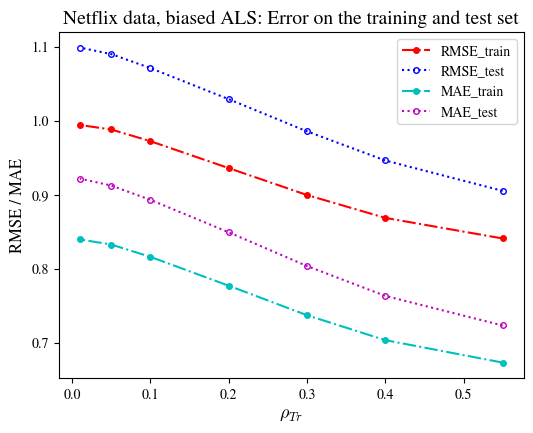

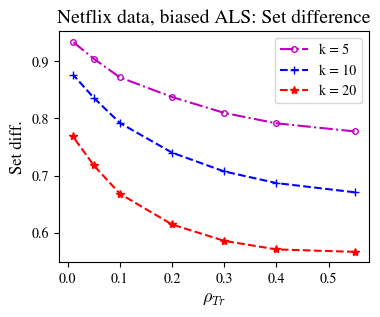

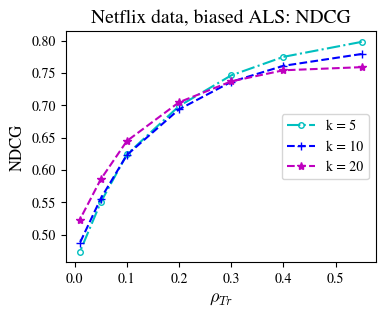

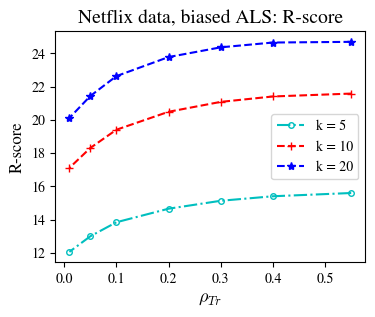

In [ ]:
synthetic_data = False
bias = True

title1, title2, title3, title4, file1, file2, file3, file4 = titles_and_file_names(synthetic_data, bias)

save_figs = True
msize = 4

fsize1 = 14
fsize2 = 12
fsize3 = 13

plt.plot(sparsity_levels, rmse_train_avg, 'ro-.', markersize=msize, label='RMSE_train')
plt.plot(sparsity_levels, rmse_test_avg, 'bo:', markerfacecolor='none', markersize=msize, label='RMSE_test')
plt.plot(sparsity_levels, mae_train_avg, 'co-.', markersize=msize, label='MAE_train')
plt.plot(sparsity_levels, mae_test_avg, 'mo:', markerfacecolor='none', markersize=msize, label='MAE_test')
plt.xlabel(r'$\rho_{Tr}$', fontsize=fsize3)
plt.ylabel('RMSE / MAE', fontsize=fsize2)
plt.title(title1, fontsize=fsize1)
fig = plt.gcf()
fig.set_size_inches(6, 4.5)
plt.legend(loc='upper right')
if save_figs:
  plt.savefig(file1, format='eps', dpi=300, bbox_inches='tight')
plt.show()

plt.plot(sparsity_levels, diff_ground_truth_averaged[:,0], 'mo-.', markerfacecolor='none', markersize=msize, label = 'k = 5')
plt.plot(sparsity_levels, diff_ground_truth_averaged[:,1], 'b+--', label = 'k = 10')
plt.plot(sparsity_levels, diff_ground_truth_averaged[:,2], 'r*--', label = 'k = 20')
plt.title(title2, fontsize=fsize1)
plt.xlabel(r'$\rho_{Tr}$', fontsize=fsize3)
plt.ylabel('Set diff.', fontsize=fsize2)
fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.legend(loc='upper right')
if save_figs:
  plt.savefig(file2, format='eps', dpi=300, bbox_inches='tight')
plt.show()

plt.plot(sparsity_levels, NDCG[:,0], 'co-.', markerfacecolor='none', markersize=msize, label = 'k = 5')
plt.plot(sparsity_levels, NDCG[:,1], 'b+--', label = 'k = 10')
plt.plot(sparsity_levels, NDCG[:,2], 'm*--', label = 'k = 20')
plt.title(title3, fontsize=fsize1)
plt.xlabel(r'$\rho_{Tr}$', fontsize=fsize3)
plt.ylabel('NDCG', fontsize=fsize2)
fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.legend(loc='center right')
if save_figs:
  plt.savefig(file3, format='eps', dpi=300, bbox_inches='tight')
plt.show()

plt.plot(sparsity_levels, R_score[:,0], 'co-.', markerfacecolor='none', markersize=msize, label = 'k = 5')
plt.plot(sparsity_levels, R_score[:,1], 'r+--', label = 'k = 10')
plt.plot(sparsity_levels, R_score[:,2], 'b*--', label = 'k = 20')
plt.title(title4, fontsize=fsize1)
plt.xlabel(r'$\rho_{Tr}$', fontsize=fsize3)
plt.ylabel('R-score', fontsize=fsize2)
fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.legend(loc='center right')
if save_figs:
  plt.savefig(file4, format='eps', dpi=300, bbox_inches='tight')
plt.show()
